In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate

from tensorflow.keras.utils import plot_model


In [13]:
input_a = Input(shape=(1), name="Wide_Input")
input_b = Input(shape=(1), name="Deep_Input")
hidden_1= Dense(30, activation='relu')(input_b)
hidden_2 = Dense(30, activation='relu')(hidden_1)
concat = concatenate([input_a, hidden_2])
output = Dense(10, name='Output')(concat)
aux_output = Dense(10, name='aux_output')(hidden_2)
concat2 = concatenate([output, aux_output])
classifier = Dense(1, name='Classifier')(concat2)
model = Model(inputs=[input_a, input_b], outputs=[classifier])

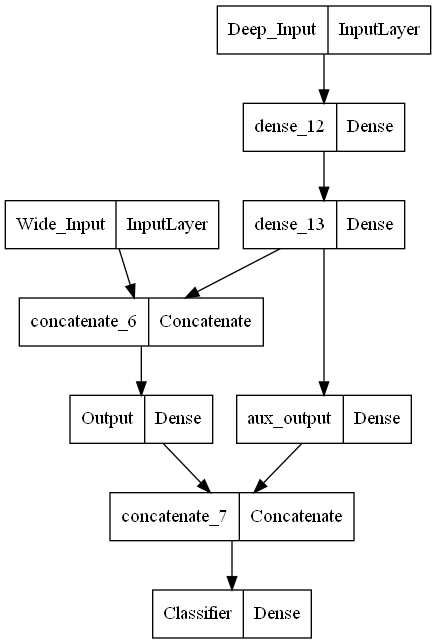

In [14]:
plot_model(model)

Putting your model into a class

In [26]:
from tensorflow.keras import Model

In [53]:
class ModelClass(tf.keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden_1 = self.hidden1(input_B)
        hidden_2 = self.hidden2(hidden_1)
        concat = concatenate([input_A, hidden_2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden_2)
        return main_output, aux_output
        

In [54]:
model = ModelClass()

In [56]:
input_a = Input(shape=[1], name="Wide_Input")
input_b = Input(shape=[1], name="Deep_Input")

model((input_a, input_b))

(<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model_class_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model_class_1')>)

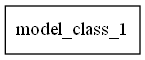

In [58]:
plot_model(model)

RESNETS

In [76]:
class DNNResidual(tf.keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)
        self.out = Dense(1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        for _ in range(1, 3):
            x = self.dense2(x)
            
        return self.out(x)

ResNet 18

In [86]:
class IdentityBlock(tf.keras.Model):
    
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters,kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.relu = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.add([x, inputs])
        return self.relu(x)
        
        

In [87]:
x = IdentityBlock(30, 3)

In [88]:
class ResNet(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.convA = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bnA = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.mpA = tf.keras.layers.MaxPool2D((3, 3))
        self.idA = IdentityBlock(64, 3)
        self.idB = IdentityBlock(64, 3)
        self.gapA = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.convA(inputs)
        x = self.bnA(x)
        x = self.act(x)
        x = self.mpA(x)
        x = self.idA(x)
        x = self.idB(x)
        x = self.gapA(x)
        return self.classifier(x)
        

In [89]:
model = ResNet(10)

In [90]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [91]:
import tensorflow_datasets as tfds

In [94]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./Labs/data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

1875/1875 [==============================] - 192s 93ms/step - loss: 0.1289 - accuracy: 0.9645
